In [1]:
import gym
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers

In [2]:
env = gym.make('CartPole-v0')

In [3]:
env.reset()

array([ 0.03836338, -0.00198904,  0.00343957, -0.01509082])

In [4]:
env.action_space

Discrete(2)

In [5]:
env.observation_space

Box(4,)

In [6]:
env.action_space.n

2

In [7]:
action = 1
observation, reward, done, info = env.step(action)

# random action and saving

In [8]:
stepping = []
env = gym.make('CartPole-v0')
# env = wrappers.Monitor(env, 'E:\Code\Python\Project')
env.reset()
episodes = 1
for _ in range(episodes):
    env.reset()
    done = False
    steps = 0
    while not done:
        steps += 1
        observation, reward, done, _ = env.step(env.action_space.sample())
    stepping.append(steps)
stepping = np.array(stepping)
print(stepping)
stepping.mean()

[20]


20.0

# random Search on action space

In [9]:
np.random.randn(4).dot(observation)
env = gym.make('CartPole-v0')

11.0
[0.45204818 0.6469446  0.66873066 0.59405465]


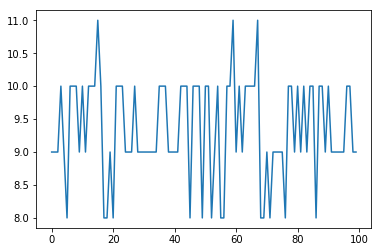

In [10]:
random_search = 100
averages = []
episodes = 10
best = 0
best_weight = None
for _ in range(random_search):
    average = 0
    weight = np.random.random(4)*2-1
#     weight = np.random.randn(4)
    for _ in range(episodes):
        observation = env.reset()
        done = False
        steps = 0
        # az ye ja start nist averaging make sense :)
        while not done and steps < 10000:
            steps +=1
            observation, reward, done, _ = env.step(0 if np.dot(weight, observation)>0 else 0)
        average += steps
    average /= episodes
    averages.append(average)
    if best < average:
        # change weights
        best = average
        best_weight = weight
print(best)
print(best_weight)
plt.plot(averages)

# Q learning Binning

In [11]:
bin_size_cart_position = 4
bin_size_cart_velocity = 4
bin_size_pole_angle = 4
bin_size_pole_velocity = 4
epsilon = 0.98
Q = np.ones((bin_size_cart_position, bin_size_cart_velocity, bin_size_pole_angle, bin_size_pole_velocity, env.action_space.n))

In [12]:
observation

array([-0.16025211, -1.78042491,  0.21412067,  2.80862011])

In [13]:
def create_bins(lower_bound, width, quantity):
    bins = []
    for low in np.arange(lower_bound, 
                     lower_bound + quantity*width + 1, width):
        bins.append((low, low+width))
    return bins

In [25]:
bin_cart_position = create_bins(lower_bound=-2.4,
                   width=4.8/bin_size_cart_position,
                   quantity=bin_size_cart_position-1)

bin_cart_position

[(-2.4, -1.2),
 (-1.2, 0.0),
 (0.0, 1.2),
 (1.1999999999999997, 2.3999999999999995)]

In [26]:
bin_cart_velocity = create_bins(lower_bound=-10,
                   width=20/bin_size_cart_velocity,
                   quantity=bin_size_cart_velocity-1)

bin_cart_velocity

[(-10.0, -5.0), (-5.0, 0.0), (0.0, 5.0), (5.0, 10.0)]

In [27]:
bin_pole_angle = create_bins(lower_bound=-41.8,
                   width=83.6/bin_size_pole_angle,
                   quantity=bin_size_pole_angle-1)

bin_pole_angle

[(-41.8, -20.9), (-20.9, 0.0), (0.0, 20.9), (20.9, 41.8)]

In [28]:
def find_bin(value, bins):
    for i in range(0, len(bins)):
        if bins[i][0] <= value < bins[i][1]:
            return i
    if bins[0][0]>value:
        return 0
    return len(bins)-1

In [29]:
bin_pole_velocity = create_bins(lower_bound=-10,
                   width=20/bin_size_pole_velocity,
                   quantity=bin_size_pole_velocity-1)

bin_pole_velocity

[(-10.0, -5.0), (-5.0, 0.0), (0.0, 5.0), (5.0, 10.0)]

In [30]:
binn = [bin_cart_position, bin_cart_velocity, bin_pole_angle, bin_pole_velocity]

In [35]:
def q_learning(env, episodes=5000, max_move=2000, random=0.99, discount=0.999, gamma=0.99, epsilon = 1, lamda = 1):
    Q = np.ones((bin_size_cart_position, bin_size_cart_velocity, bin_size_pole_angle, bin_size_pole_velocity, env.action_space.n))
    flag = False
    alling = []
    for i in range(episodes):
        observation = env.reset()
        done = False
        steps = 0
        rewards = 0
#         print('========================================')
        while not done and steps<max_move:
            steps += 1
            greedy = np.random.random(1)[0]>epsilon
            if greedy:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[find_bin(observation[0], binn[0]), find_bin(observation[1], binn[1]), find_bin(observation[2], binn[2]), find_bin(observation[3], binn[3])])
            observation_new, reward, done, _ = env.step(action)
            reward = 0
            if done:
                reward = -300 
            rewards += reward
# #             print(observation[0], binn[0])
#             print(observation[1], binn[1])
#             print(observation[2], binn[2])
#             print(observation[3], binn[3])
#             print(find_bin(observation[0], binn[0]), find_bin(observation[1], binn[1]), find_bin(observation[2], binn[2]), find_bin(observation[3], binn[3]), action)
            Q[find_bin(observation[0], binn[0]), find_bin(observation[1], binn[1]), find_bin(observation[2], binn[2]), find_bin(observation[3], binn[3]), action] = lamda * (reward + gamma * np.max(Q[find_bin(observation_new[0], binn[0]), find_bin(observation_new[1], binn[1]), find_bin(observation_new[2], binn[2]), find_bin(observation_new[3], binn[3]), action])) + (1 - lamda) * Q[find_bin(observation[0], binn[0]), find_bin(observation[1], binn[1]), find_bin(observation[2], binn[2]), find_bin(observation[3], binn[3]), action]
#             print(Q[find_bin(observation[0], binn[0]), find_bin(observation[1], binn[1]), find_bin(observation[2], binn[2]), find_bin(observation[3], binn[3])])
            observation = observation_new
#             env.render(mode="rgb_array")
#             input()
        lamda *= discount
        alling.append(rewards)
        if i % 16 == 0:
            epsilon *= random
            if (i % 256 == 0 and epsilon < 0.25) or flag:
                flag = True
                epsilon = 0.25
    plt.plot(alling)
    return Q

2304
2320
2336
2352
2368
2384
2400
2416
2432
2448
2464
2480
2496
2512
2528
2544
2560
2576
2592
2608
2624
2640
2656
2672
2688
2704
2720
2736
2752
2768
2784
2800
2816
2832
2848
2864
2880
2896
2912
2928
2944
2960
2976
2992
3008
3024
3040
3056
3072
3088
3104
3120
3136
3152
3168
3184
3200
3216
3232
3248
3264
3280
3296
3312
3328
3344
3360
3376
3392
3408
3424
3440
3456
3472
3488
3504
3520
3536
3552
3568
3584
3600
3616
3632
3648
3664
3680
3696
3712
3728
3744
3760
3776
3792
3808
3824
3840
3856
3872
3888
3904
3920
3936
3952
3968
3984
4000
4016
4032
4048
4064
4080
4096
4112
4128
4144
4160
4176
4192
4208
4224
4240
4256
4272
4288
4304
4320
4336
4352
4368
4384
4400
4416
4432
4448
4464
4480
4496
4512
4528
4544
4560
4576
4592
4608
4624
4640
4656
4672
4688
4704
4720
4736
4752
4768
4784
4800
4816
4832
4848
4864
4880
4896
4912
4928
4944
4960
4976
4992


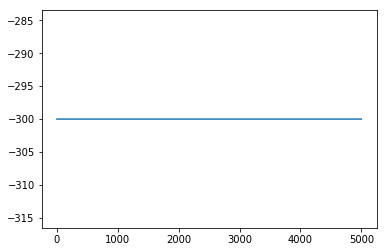

In [36]:
Q = q_learning(env)

In [38]:
Q


array([[[[[ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00]],

         [[ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00]],

         [[ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00]],

         [[ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00]]],


        [[[ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00],
          [ 1.00000000e+00,  1.00000000e+00]],

         [[ 1.00000000e+00,  1.00000000e+00],
          [-1.40480253

In [49]:
def run(env, Q, max_move=2000):
    observation = env.reset()
    env.render()
    done = False
    steps = 0
    while not done and steps<max_move:
        steps += 1
        action = np.argmax(Q[find_bin(observation[0], binn[0]), find_bin(observation[1], binn[1]), find_bin(observation[2], binn[2]), find_bin(observation[3], binn[3])])
        observation, reward, done, _ = env.step(action)
    return steps

In [50]:
run(env, Q)

60